In [111]:
# import packages
import numpy as np
import math as math
from astropy import units as u
import astropy.constants as const

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

## What we're doing in math terms

Reference paper: [Gaudi et al](https://www.astronomy.ohio-state.edu/gaudi.1/rmeffect.pdf)

We assume the two-body reference frame, calculating everything from the rest frame of the star.

First, here's our equation for P, from Kepler's 3rd law:
$$ P = \sqrt{\frac{4\pi^{2}a^{3}}{GM_{*}}} $$ 


$r_{0} = a(1 - e)$ and $\theta_{0} = 0$

For our computation, we set a grid size `n` and compute $r$ and $\theta$ at each time step from 0 to P in `n` steps. If we want to see the behavior over multiple orbits, we scale the time array by `nP`

At each time step, we calculate $\Delta\theta = \sqrt{GM_{*}}\frac{(1 + ecos\theta)^{2}}{a(1-e^{2})^{3/2}}\Delta t$ using the previous step's $~\theta$ to get $\theta_{current} = \theta_{previous} + \Delta\theta$

We can calculate $r(\theta_{current}) = \frac{a(1 - e^{2})}{1 +  e cos\theta}$

    dtheta = ((np.sqrt(const.G * mstar)) * (1 + e * np.cos(current_theta))**2 * ( a * (1 - e**2))**(-3/2) * dt).decompose()


For cases where the planet is **transiting**, we can calculate the impact parameter, _b_ ([Winn et al, 2010](https://arxiv.org/pdf/1001.2010.pdf)):

$$ b_{tra} = \frac{a~cos~i}{R_*}\left(\frac{1 - e^2}{1 + e~sin~\omega}\right) $$



In [209]:
def get_a(mstar, m_p, P):
    """
    Calculate semi-major axis, a, using Kepler's Third law
    
    Inputs:
        mstar, stellar mass
        P, planet period
    Returns:
        a, semi-major axis (AU)
    
    """
    # period from kepler's third law
    # P = np.sqrt(((4*np.pi**2) / (const.G * mstar)) * a**3 )  
    # solve for a:
    
    a = (((const.G * (mstar + m_p) * P**2) / (4*np.pi**2))**(1/3)).to(u.AU)
    return a


In [186]:
def get_incl(b, a, rstar, e, omega):
    """For a given impact parameter, b, get the inclination"""
    #b = ((a * math.cos(incl) / rstar)*((1 - e**2)/(1 + e * math.sin(omega)))).decompose() # assume planet is passing right through the middle of the disk of the star
    incl = math.acos((b / a) * rstar * (1 + e * math.sin(omega)) / (1 - e**2))
    return incl

In [256]:
# set system initial conditions

# star
mstar = 0.5 * u.M_sun  # stellar mass
rstar = 0.5 * u.R_sun  # stellar radius
Pstar = 30 * u.d # stellar rotation period


# planet
mp = 20 * u.M_earth # 1 * u.M_jupiter # planet mass
rp = 4 * u.R_earth # 1 * u.R_jup # planet radius


In [355]:
# set up orbit

# set orbital parameters

P = 20 * u.day
a = get_a(mstar, mp, P)
e = 0.1  # orbital eccentricity
omega = np.pi * 0.5
b = 0 # 0.5
incl = 0.5*np.pi # get_incl(b, a, rstar, e, omega)# np.pi * 0.5  # assume we are observing in-plane, i.e. inclination = 90 deg

K = ((2 * math.pi * const.G) / P)**(1/3) * ((mp * math.sin(incl))/(mp + mstar)**(2/3)) / (math.sqrt(1 - e**2))
print(f"K, semi-amplitude = {K.decompose()} m/s ")


# initialize orbit
theta0 = 0.  # initial longitude

n = 10000  # number of steps


# set observation initial conditions

dt = P / n     # duration of time step
print(f"dt = {dt.to(u.hr)} for {n} steps")
nP = 2 # number of periodts the time goes for
t_array = np.linspace(0, P*nP, n*nP)  # array of time steps from 0 to P
r0 = a * (1 - e)  # initial planet position, default: periastron

# using v_p, rstar, can get tdur of transit time
#   unless orbit is very elliptical, vp will not change that much over the course of the transit, 
#   Winn, 2.3 eq 14 (p.58

# We assume b = 0 

if b < 1:
    dur_circ = ((P / (np.pi * u.rad)) * 
           np.arcsin((rstar / a) * np.sqrt((1 + (rp/rstar))**2 - b**2) / (np.sin(incl)))).to(u.hr)
    correction = np.sqrt(1 - e**2) / (1 + e*np.sin(omega)) # correct for e > 0
    dur = dur_circ * correction
    print(f"Predicted transit duration: {dur:.6}")
    print(f"\t(e = {e}: correction: {correction:.6} x circular orbit duration {dur_circ:.6})")
    print(f"Predicted # pts in transit (dur/dt): {int(np.floor((dur / dt).decompose()))}") # points in transit
else:
    print(f"b = {b:.5}, no transit")
    
# compare to when planet is in y-value of star disk at transit and eclipse

# initialize array of longitudes for each time step
thetas = np.zeros(len(t_array))
thetas[0] = theta0

# initialize array of radii
r = np.zeros(len(t_array)) * u.AU
r[0] = r0

# initialize x, y arrays
x, y = np.zeros(len(t_array)) * u.AU, np.zeros(len(t_array)) * u.AU
x[0] = r0 * np.cos(theta0)
y[0] = r0 * np.sin(theta0)

# debug: track each theta, dtheta
#current_thetas = np.zeros(len(t_array))
#dthetas = [0.]
debug = False

# calculate thetas for conjunction (!!! this is approximate!!!)
t_conj = (P*np.arange(0,nP + 1)).to(u.yr)
# if dt is 1hr, how many points should be during transit (on disk of star)? should be ~31
t_ingress = (P*np.arange(0,nP + 1)).to(u.yr) - dur*0.5
t_egress = (P*np.arange(0,nP + 1)).to(u.yr) + dur*0.5


# calculate r, theta at each time step
for i in range(len(t_array)):
    # get time
    t = t_array[i]
    # get current longitutde
    if debug: print(f"i: {i}, t: {t.decompose()}")
    current_theta = thetas[i] # thetas[np.where(t_array == t)[0][0]]  # current value of theta
    # current_thetas.append(current_theta) # debug only
    
    # calculate dtheta
    dtheta = ((np.sqrt(const.G * mstar)) * (1 + e * np.cos(current_theta))**2 * ( a * (1 - e**2))**(-3/2) * dt).decompose()
    # dthetas.append(dtheta)  # debug only
    
    # add to get new longitude 
    new_theta = current_theta + dtheta.value
    # save the new theta longitude to the array
    if i+1 == len(t_array):
        pass
    else:
        thetas[i+1] = new_theta
    
    # because we know theta, we can get the position
    current_r = a * (1 - e**2) / (1 + e * np.cos(current_theta))
    r[i] = current_r
    x[i] = current_r * np.cos(current_theta)  # ellipse major axis for omega = 0
    y[i] = current_r * np.sin(current_theta)  # ellipse minor axis for omega = 0
    
    #print(f"time = {t:.3}, theta + dtheta =  {current_theta:.3} + {dtheta:.3} = {new_theta:.3}, r = {current_r}")

#thetas = thetas[:-1]
#dthetas = dthetas[:-1]

K, semi-amplitude = 7.516337936123019 m / s m/s 
dt = 0.048 h for 10000 steps
Geometric transit duration: 3.01389 h
	(e = 0.1: correction: 0.904534 x circular orbit duration 3.33198 h)
Rough # in transit (dur/dt): 62


On the flip side, we can also predict transit times for an observer positioned at periastron.

We use equation (14) from Winn for a **circular orbit**:

$$ T_{tot} = \frac{P}{\pi}sin^{-1}\left(\frac{R_*}{a}\frac{\sqrt{(1+k)^2 - b^2}}{sin~i}\right) $$


In [331]:
left_edge, right_edge = rstar.to(u.AU).value * np.array([-1,1])

debug = False 

x_orbit = np.array([q.value for q in x])  # x-dimension of ellipse (along major axis)
y_orbit = np.array([q.value for q in y])  # y-dimension of ellipse (along minor axis)

# select y positions when center of planet is in front of disk of star
mask_overlap = (y_orbit >= left_edge) & (y_orbit <= right_edge) 
# print("planet + star overlap: \n", list(zip(x_orbit[mask_overlap], y_orbit[mask_overlap])))
# print(f"planet + star overlap at {len(y_orbit[mask_overlap])} time points")

# select y positions when planet is _transiting_
t_transit = t_array[mask_overlap & (x_orbit > 0) & (t_array < P ) ]
transit_y = y_orbit[mask_overlap & (x_orbit > 0) & (t_array < P ) ]
print(f"{len(transit_y)} points where planet is in front of star")
if debug: print(f"y positions, planet in front of star ({len(transit_y)}):", transit_y)

# select y positions 
mask_around_transit = (y_orbit >= left_edge*2) & (y_orbit <= right_edge*2) & (x_orbit > 0)
around_transit_y = y_orbit[mask_around_transit]

# select y positions when planet is in _eclipse_
eclipse_y = y_orbit[mask_overlap & (x_orbit < 0) & (t_array < P )]
print(f"{len(eclipse_y)} points where planet is in eclipse")
if debug: print(f"y positions, planet behind star: ({len(eclipse_y)})", eclipse_y)

# todo: use mask to find what RV points are in transit
# print(v_star[mask_overlap], r"Needs to be projected in sin $\theta$")
#   there should be ~3 points in front, so check indices issue
#   projected velocity should be zero at transit and eclipse 
#   using dtheta will give correct velocity vector


overlap_theta = np.array(thetas)[mask_overlap]
overlap_r = np.array([q.value for q in r])[mask_overlap]

58 points where planet is in front of star
71 points where planet is in eclipse


1. We start with `testN` test points in a square with side length $2R_{star}$.
2. We find `starN`, the number of points with position (x,y) within in the radius of the star:  
    $$ condition(in~star) =  \sqrt{x^2 + y^2} \lt R_{star} $$
   
   We work with this number, `starN` = `testN[condition(in star)] / testN` for the rest of the exercise.  
   

3. For a given position of the planet in front of the disk, we get the number of points within the radius of the planet:
    condition
    $$ condition(in~planet) = \sqrt{((x - x_p(t))^2 + (y - y_p(t))^2)} \lt R_{planet} $$ 
    
    We get the transit depth:
    $$ d = \frac{N_{star}(condition(in~planet))}{N_{star}}  $$
    
4. For the points in the star disk and in the planet disk, we get the fraction of light blocked when the planet moves through the blue or red or white region.

    $$ condition(in~blue) = x_{blue,~L} < x < x_{blue,~R}  $$ 
    
    $$ F_{in~blue} = \frac{ N_{p}(condition(in~blue))}{N_{star}} $$   
    
    (same for red and white)
 
5. We add up the fractional change to the nominal transit depth $d$ measured at time $t$:
    $$ F_{tot} = F_{in~blue} - F_{in~red} $$ 
    
    Note we do not change $F_{tot}$ for transit positions over the "white" part of the star because there is no radial velocity contribution. 
    
6. We plot $F_{tot}$ as a function of time. 

#### We can also add sunspots! 

The rotational periodt of Sun-like stars is 28 days at the equator and longer (~35 days), 
  in part because of the period being the same at all latitudes, so the velocity needing to be different 
  to keep that true. 
  
  Also, differential velocity due to convection.
  
  latitude = $\phi$ (0 at equator, $\pi/2$ at the North pole
  
  $ C = 2\pi r$ at the equator and
  
  $ C = 2\pi r cos\phi $ at other latitudes.
  
  $$ v_{rot, lat} = \frac{2\pi r_{star} cos\phi}{P_{star}} $$

In [333]:
# creating a sunspot

ss_lat = 0             # latitude on star
ss_long = np.pi*0.25  # angle from periastron meridian
ss_x = rstar.to(u.AU) * np.sin(ss_long) 
ss_y = rstar.to(u.AU) * np.sin(ss_lat)

ss_r = np.sqrt((1000 * 1e-6*np.pi*const.R_sun**2).to(u.AU**2)) # measured in MH, millionths of a Solar hemisphere

# sunspot moves really slowly compared to planet transit
ss_vrot = (2*np.pi * rstar.to(u.AU) * np.cos(ss_lat) / Pstar).decompose()

progress = (ss_vrot * dur).to(u.AU) / (2 * rstar * np.cos(ss_lat)).to(u.AU)

print(f"sunspot moves across {100 * progress:.3}% of its chord during transit")

sunspot moves across 1.32% of its chord during transit


In [334]:
ss_r

<Quantity 0.00026066 AU>

In [335]:
## now we think about the star as a carton of neapolitan ice cream or 
#   the French national flag 🇫🇷 and we find how much of each area 
#    is blocked by the planet

# x_boundaries = [left_edge, left_edge*(1/3), right_edge*(1/3), right_edge]  

## but we can also make the blue/red shift a gradient based on disk position
#     effectively, making the white zone width=0

x_boundaries = [left_edge, 0, 0, right_edge]

testN = 50000
pl_r = rp.to(u.AU).value
st_r = rstar.to(u.AU).value

# random points on disk of star
test_x = np.random.random(testN) * (right_edge - left_edge) + left_edge 
test_y = np.random.random(testN) * (right_edge - left_edge) + left_edge
test_r = np.sqrt(test_x**2 + test_y**2)

# select only points on disk of star
star_mask = test_r < st_r
star_xtest = test_x[star_mask]
star_ytest = test_y[star_mask]
starN = len(star_xtest)

pl_y = 0 # b = 0, so planet is in the plane of the observer

# tally up the change in RV due to Ross-McL
drvs = np.zeros(len(around_transit_y))

orbit_drvs = np.zeros(len(y_orbit)) # track for whole orbit

debug = False 

# of points on star disk, select points on disk of planet as a function of time
for q in range(len(around_transit_y)): 
    
    drv = 0.
    # horizontal position relative to (0,0) at center of star disk
    position = around_transit_y[q]

    # index of this position relative to full-orbit array
    yi = [i for i in range(len(y_orbit)) if y_orbit[i] == position][0]
    print(f"position: {position} at index in y_orbit:",yi)
    
    # is the point in the disk of the planet?
    test_rp = np.sqrt((star_xtest - position)**2 + (star_ytest - pl_y)**2)
    in_planet_mask =  test_rp < pl_r
    pl_xtest = star_xtest[in_planet_mask]
    pl_ytest = star_ytest[in_planet_mask]
    depth_mc = len(pl_xtest) / starN
    print(f"transit depth = {len(pl_xtest)}/{starN} = {depth_mc}")
    
    # we are seeing the observer-oriented component of vrot, vrot * (y/rstar)
    # we use |y|/rstar as a scaling ratio for the flux 
    obs_vrot = np.abs(position * u.AU) / rstar.to(u.au)
    
    # is the point in the blue part of the star?
    # less blue light -> looks more red-shifted (moving away from viewer)
    blue_mask = (pl_xtest > x_boundaries[0]) & (pl_xtest < x_boundaries[1]) 
    blue_blocked = len(pl_xtest[blue_mask]) / starN
    drv += blue_blocked * obs_vrot
    if debug: print(f"{blue_blocked*100}% blue light blocked")
    
    # is the point in the white part of the star?
    # no contribution to red/blue shift
    white_mask = (pl_xtest > x_boundaries[1]) & (pl_xtest < x_boundaries[2]) 
    white_blocked = len(pl_xtest[white_mask]) / starN
    if debug: print(f"{white_blocked*100}% white light blocked")
    
    # is the point in the red part of the star?
    # less red light -> looks more blue-shifted (moving towards viewer)
    red_mask = (pl_xtest > x_boundaries[2]) & (pl_xtest < x_boundaries[3]) 
    red_blocked = len(pl_xtest[red_mask]) / starN
    drv -= red_blocked * obs_vrot
    if debug: print(f"{red_blocked*100}% red light blocked")
        
    # is the point on the sunspot?
    # TODO
    
    drvs[q] = drv
    orbit_drvs[yi] = drv
    
    print(f"sum of red/blue-shifted area fractions at this position: {drv}\n")
    

# how much of the star's light is that? 
#    starlight * (area planet / area star)
#    if blue area: subtract
#    if red area: add
#    if hwite area: nothing



position: 0.0 at index in y_orbit: 0
transit depth = 225/39068 = 0.005759189106173851
sum of red/blue-shifted area fractions at this position: 0.0

position: 7.949819655727781e-05 at index in y_orbit: 1
transit depth = 207/39068 = 0.005298453977679943
sum of red/blue-shifted area fractions at this position: -9.538849569785642e-05

position: 0.00015899635437275361 at index in y_orbit: 2
transit depth = 191/39068 = 0.004888911641240913
sum of red/blue-shifted area fractions at this position: -0.00032379573218687064

position: 0.0002384944304000086 at index in y_orbit: 3
transit depth = 202/39068 = 0.005170471997542746
sum of red/blue-shifted area fractions at this position: -0.0005303246769650515

position: 0.00031799238159269485 at index in y_orbit: 4
transit depth = 198/39068 = 0.005068086413432989
sum of red/blue-shifted area fractions at this position: -0.0006930971785367222

position: 0.0003974901649045797 at index in y_orbit: 5
transit depth = 227/39068 = 0.005810381898228729
sum o

transit depth = 0/39068 = 0.0
sum of red/blue-shifted area fractions at this position: 0.0

position: -0.002432490898504875 at index in y_orbit: 9970
transit depth = 22/39068 = 0.0005631207126036654
sum of red/blue-shifted area fractions at this position: 0.000589096076287437

position: -0.0023530123278239557 at index in y_orbit: 9971
transit depth = 96/39068 = 0.002457254018634176
sum of red/blue-shifted area fractions at this position: 0.0024866099142239386

position: -0.0022735324788338033 at index in y_orbit: 9972
transit depth = 173/39068 = 0.004428176512747005
sum of red/blue-shifted area fractions at this position: 0.004329716804266413

position: -0.0021940513945617026 at index in y_orbit: 9973
transit depth = 214/39068 = 0.005477628749872018
sum of red/blue-shifted area fractions at this position: 0.005168598475440712

position: -0.002114569118036011 at index in y_orbit: 9974
transit depth = 225/39068 = 0.005759189106173851
sum of red/blue-shifted area fractions at this positio

position: -0.003990003767038554 at index in y_orbit: 19951
transit depth = 0/39068 = 0.0
sum of red/blue-shifted area fractions at this position: 0.0

position: -0.003910558936757378 at index in y_orbit: 19952
transit depth = 0/39068 = 0.0
sum of red/blue-shifted area fractions at this position: 0.0

position: -0.003831111985128951 at index in y_orbit: 19953
transit depth = 0/39068 = 0.0
sum of red/blue-shifted area fractions at this position: 0.0

position: -0.0037516629551462622 at index in y_orbit: 19954
transit depth = 0/39068 = 0.0
sum of red/blue-shifted area fractions at this position: 0.0

position: -0.003672211889804502 at index in y_orbit: 19955
transit depth = 0/39068 = 0.0
sum of red/blue-shifted area fractions at this position: 0.0

position: -0.003592758832101025 at index in y_orbit: 19956
transit depth = 0/39068 = 0.0
sum of red/blue-shifted area fractions at this position: 0.0

position: -0.0035133038250353145 at index in y_orbit: 19957
transit depth = 0/39068 = 0.0
sum

In [336]:
ss_r

<Quantity 0.00026066 AU>

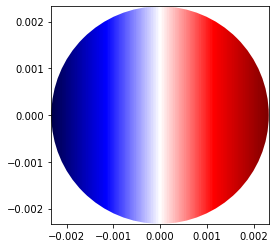

In [337]:
fig = plt.figure()
ax = fig.add_subplot()

xmap, ymap, rval = 0, 0, rstar.to(u.AU).value
img = ax.imshow(np.linspace(-1,1,100).reshape(1,-1), cmap='seismic',
                extent=[xmap - rval, xmap + rval, ymap - rval, ymap + rval ], origin='lower')
circle = plt.Circle((0,0),rval, alpha=0.5,   # fc='thistle',
                          label=r'star ({} $R_\odot$)'.format(rstar.value), transform=ax.transData)

img.set_clip_path(circle)

# add sunspot
# spot = ax.add_artist(plt.Circle((ss_x.value, ss_y.value), ss_r.value, color='black'))

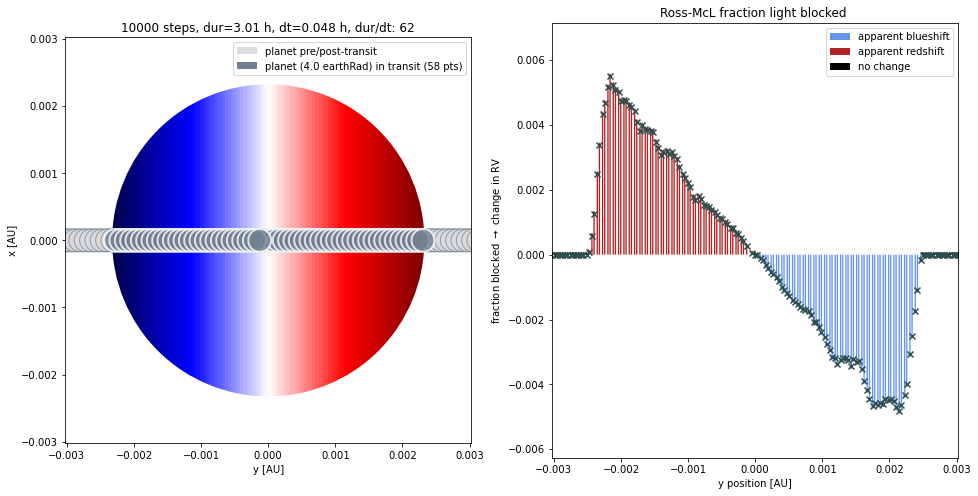

In [338]:
fig = plt.figure(figsize=(16,8))

# track R-M on star disk
ax = fig.add_subplot(121, aspect='equal')

"""
# back when I was thinking about planets as squares
for i in np.arange(len(transit_y)):
    ax.add_patch(Rectangle((transit_y[i]-rp.to(u.AU).value,-rp.to(u.AU).value),
                           2*rp.to(u.AU).value,2*rp.to(u.AU).value,
                           color='slategrey',lw=2,alpha=0.8,zorder=9))
ax.add_patch(Rectangle((transit_y[0]-rp.to(u.AU).value,-rp.to(u.AU).value),
                       2*rp.to(u.AU).value,2*rp.to(u.AU).value,
                       color='pink',lw=2,alpha=0.8,zorder=9))
"""
# rotating regions of star
# rect_width = 2*rstar.to(u.AU).value / 3
# ax.add_patch(Rectangle((x_boundaries[0],-right_edge),rect_width, 2*right_edge,
#                        fc='cornflowerblue',zorder=1,label='blueshift (towards)'))
# ax.add_patch(Rectangle((x_boundaries[1],-right_edge),rect_width, 2*right_edge,
#                        fill=None,ec='white',zorder=1,label='no shift (lateral)'))
# ax.add_patch(Rectangle((x_boundaries[2],-right_edge),rect_width, 2*right_edge,
#                        fc='firebrick',zorder=1,label='redshift (away)'))

# circular star footprint
# monotonically-increasing color bar
xmap, ymap, rval = 0, 0, rstar.to(u.AU).value
img = ax.imshow(np.linspace(-1,1,100).reshape(1,-1), cmap='seismic',
                extent=[xmap - rval, xmap + rval, ymap - rval, ymap + rval ], origin='lower')
circle = plt.Circle((0,0),rval, alpha=0.5,   # fc='thistle',
                          label=r'star ({} $R_\odot$)'.format(rstar.value), transform=ax.transData)
img.set_clip_path(circle)
#ax.add_artist(circle)

# sunspot! 
# spot = ax.add_artist(plt.Circle((ss_x.value, ss_y.value), ss_r.value, color='black'))

# for legend reasons only
_planet = ax.add_artist(plt.Circle((0,0),rp.to(u.AU).value,
                                    fc='gainsboro',label='planet pre/post-transit'))
planet = ax.add_artist(plt.Circle((0,(b*rstar).to(u.AU).value),rp.to(u.AU).value,
                                   fc='slategrey',
                                  label=f'planet ({rp}) in transit ({len(transit_y)} pts)'))


# add planet positions before/after transit
for i in np.arange(len(around_transit_y)):
    ax.add_artist(plt.Circle((around_transit_y[i], (b*rstar).to(u.AU).value),rp.to(u.AU).value,
                              ec='slategrey',fc='gainsboro', alpha=0.7))
# add planet positions in transit
for i in np.arange(len(transit_y)):
    ax.add_artist(plt.Circle((transit_y[i],(b*rstar).to(u.AU).value),rp.to(u.AU).value,
                            ec='white',lw=2, fc='slategrey',alpha=0.8))

# formatting 
ax.set_xlabel("y [AU]")
ax.set_ylabel("x [AU]")
ax.set_title(f"{n} steps, dur={dur.to(u.hr):.3}, dt={dt.to(u.hr):.3}, dur/dt: {int(np.floor((dur / dt).decompose()))}")

ax.set_xlim(left_edge*1.3,right_edge*1.3)
ax.set_ylim(left_edge*1.3,right_edge*1.3)

plt.legend(loc='upper right')

##### plot the contribution to RV from Rossiter-McLaughlin
ax2 = fig.add_subplot(122)

# for legend purposes only
plt.arrow(0,0,0,0,width=0,facecolor='cornflowerblue', edgecolor='none',
         label="apparent blueshift")
plt.arrow(0,0,0,0,width=0,facecolor='firebrick', edgecolor='none',
         label="apparent redshift")
plt.arrow(0,0,0,0,width=0,facecolor='black', edgecolor='none',
         label="no change")

width = np.diff(around_transit_y)[0]*0.25
# loop through positions we examined
for q in range(len(drvs)):
    if drvs[q] > 0: # apparent red-shift
        plt.arrow(x=around_transit_y[q], y=0, dx=0, dy=drvs[q], 
                  width=width,facecolor='firebrick', edgecolor='none')
    elif drvs[q] < 0: # apparent blue-shift
        plt.arrow(x=around_transit_y[q], y=0, dx=0, dy=drvs[q], 
                  width=width, facecolor='cornflowerblue', edgecolor='none')
    else:
        plt.arrow(x=around_transit_y[q], y=0, dx=0, dy=drvs[q], 
                  width=width,facecolor='black', edgecolor='none')


ax2.scatter(around_transit_y,drvs,marker='x',fc='darkslategrey') # x, y, u, v

# formatting 
ax2.set_xlim(left_edge*1.3,right_edge*1.3)
ax2.set_ylim((drvs.min()*1.3,drvs.max()*1.3))
ax2.set_xlabel("y position [AU]")
ax2.set_ylabel(r"fraction blocked $\rightarrow$ change in RV")
ax2.set_title(r"Ross-McL fraction light blocked ")
plt.legend()

plt.savefig("areaBlockedRatio_up_down_RM.png")

# vrot star ~ 1.6 km/s

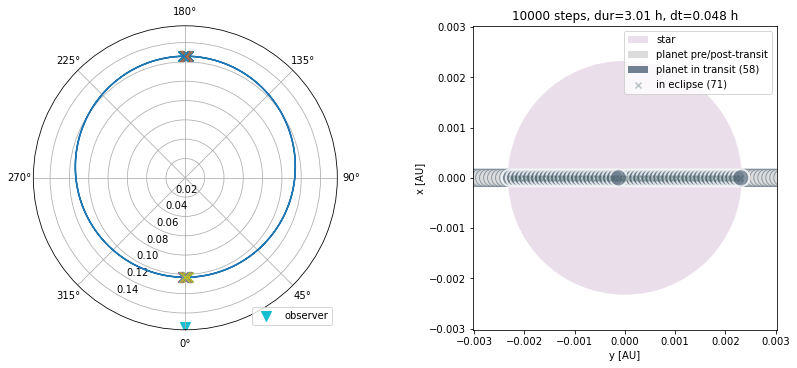

In [339]:
## we then plot the planet relative to the orbit of the star

# set up figure
fig = plt.figure(figsize=(12,5),constrained_layout=True)

# ---------------------------------------------------------------- # 
# plot path of ellipse
ax = fig.add_subplot(121, projection='polar')
ax.plot(thetas, [i.value for i in r]) #, s=2)
for i in np.arange(len(overlap_theta)):
    ax.scatter(overlap_theta[i], overlap_r[i], marker='x',s=100, zorder=10)
    # ax.arrow(overlap_theta[i], overlap_r[i], overlap_theta[i]*2, 100, width=1e-5,color='grey')
# plot observer
ax.scatter(0,r[0]*1.5, marker='v',s=100, label='observer')


# add labels
ax.set_rmax((r.max()*1.25).value)
#ax.set_rticks([2,4,6,8])  # Fewer radial ticks ([0.5, 1, 1.5, 2])
ax.set_rlabel_position(-30.5)  # Move radial labels away from plotted line
ax.set_theta_zero_location("S")
ax.legend(loc='lower right')
ax.grid(True)

# ---------------------------------------------------------------- # 
# plot on face of star
ax2 = fig.add_subplot(122, aspect='equal')
# ax2.axis([-2, 2, -2, 2])
# ax2.axis("equal")
star = ax2.add_artist(plt.Circle((0,0),rstar.to(u.AU).value,fc='thistle',
                                 alpha=0.5,label='star'))

# for legend reasons only
_planet = ax2.add_artist(plt.Circle((0,0),rp.to(u.AU).value,
                                    fc='gainsboro',label='planet pre/post-transit'))
planet = ax2.add_artist(plt.Circle((0,0),rp.to(u.AU).value,
                                   fc='slategrey',label=f'planet in transit ({len(transit_y)})'))

# add points before/after transit
for i in np.arange(len(around_transit_y)):
    ax2.add_artist(plt.Circle((around_transit_y[i],0),rp.to(u.AU).value,
                              ec='slategrey',fc='gainsboro', alpha=0.7))
# add points in transit
for i in np.arange(len(transit_y)):
    ax2.add_artist(plt.Circle((transit_y[i],0),rp.to(u.AU).value,
                            ec='white',lw=2, fc='slategrey',alpha=0.8))
# add points in eclipse
ax2.scatter(eclipse_y, np.zeros(len(eclipse_y)),
            alpha=0.3, color='darkslategrey', marker='x', label=f'in eclipse ({len(eclipse_y)})')

# formatting 
ax2.set_xlabel("y [AU]")
ax2.set_ylabel("x [AU]")
ax2.set_title(f"{n} steps, dur={dur.to(u.hr):.3}, dt={dt.to(u.hr):.3}")

ax2.set_xlim(left_edge*1.3,right_edge*1.3)
ax2.set_ylim(left_edge*1.3,right_edge*1.3)

ax2.legend(loc='upper right')


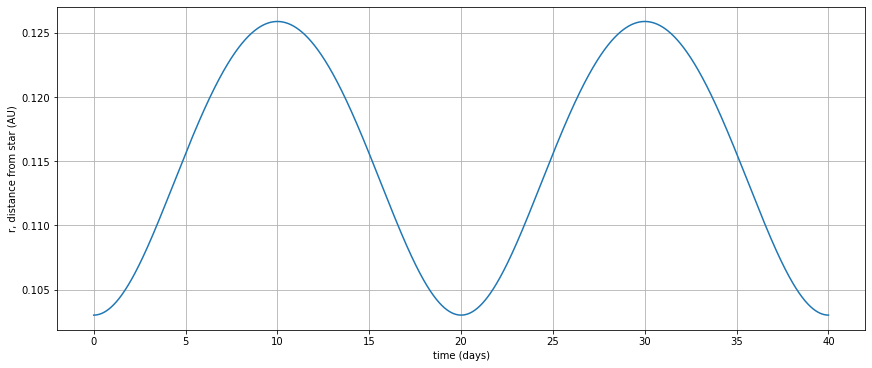

In [340]:
# set up figure
fig = plt.figure(figsize=(12,5),constrained_layout=True)

# ---------------------------------------------------------------- # 
# plot path of ellipse
ax = fig.add_subplot()
ax.plot(t_array, [i.value for i in r]) #, s=2)

ax.set_xlabel("time (days)")
ax.set_ylabel("r, distance from star (AU)")
plt.grid()

Recall $\Delta\theta = \sqrt{GM_{*}}\frac{(1 + ecos\theta)^{2}}{a(1-e^{2})^{3/2}}\Delta t$

Is it $$ v_{p} = \frac{dr}{dt}\hat{r} + r\frac{d\theta}{dt}\hat{\theta} $$ 
 or is it 
 $$ v_{p}^2 = (\frac{dr}{dt}\hat{r})^2 + r^2(\frac{d\theta}{dt}\hat{\theta})^2 $$

$$ v_{p} = \sqrt{\frac{GM}{a(1-e^{2})}}\frac{esin\theta}{1 + ecos\theta} + \sqrt{\frac{GM}{a(1-e^{2})}}(1 + e cos\theta) $$

For now, we just consider the second term:

$$ v_{p} = \sqrt{\frac{GM}{a(1-e^{2})}}(1 + e cos\theta) $$

$$ v_{*} = \frac{m_{p}}{m_{p} + m_{*}}v_{p}$$ 

Applying some trigonometry, the  line-of-sight velocity   for an observer at periastron is a component of the above $v_{*}$:

$$ v_{*,radial} =  v_{*,total}sin\theta $$

* * *
_(I think below is another way to calculate the stellar velocity, but I'm not going to worry about it too much for now)_

Now attempting to calculate $\frac{dz}{dt}$:

$$ \frac{dz}{dt} = \frac{\frac{2\pi}{P}a sin(i)}{\sqrt{1 - e^{2}}}(cos(\omega + f) + e~cos(\omega))$$

$$ v_{r} = V_{z}  + \frac{m_{p}}{m_{p} + m_{star}}\frac{\frac{2\pi}{P}a sin(i)}{\sqrt{1 - e^{2}}}(cos(\omega + f) + e~cos(\omega)) $$

$$ v_{r} = V_{z}  + K(cos(\omega + f) + e~cos(\omega)) $$

For simplicity, we assume $V_{z}$ (proper motion velocity?) $ = 0 $
and 
$$ K = \frac{m_p}{m_p + m_{star}}\frac{\frac{2\pi}{P}asin(i)}{\sqrt{1 - e^2}} $$ 


* * * 


We then take into account the contribution to the radial (measured) velocity from the rotation of the star.

$$ v_{tot} = v_{planet \rightarrow star} sin\theta + v_{rot} sin\theta $$

We assume a constant $v_{rot}$ at the equator of the star. For $i$ points on the star disk, 

$$ \sum_i v_{rot} = \sum_i v_{rot} sin(\theta_i) \\
= \int_{\pi/2}^{\pi/2} v_{rot} sin\theta d\theta \\
= 0 $$


so it follows

$$ v_{tot} = v_{planet \rightarrow star} sin\theta  $$


_However_ when part of the star is blocked by the planet, we have to take that into account. We recall $F_{tot}$, the sum of the contributions of apparent redshift and blueshift from the planet blocking part of of the star.

$$  v_{tot}(t) = v_{planet \rightarrow star} sin\theta + F_{tot} v_{rot} sin\theta_i $$ 


### vis-viva

$$ v_{v-v}^2 = GM_{star}\left(\frac{2}{r} - \frac{1}{a}\right)  $$

In [354]:

# calculating an alternate way using vis-viva

vv = np.sqrt(const.G * mstar * ((2/r) - (1/a)))

# NOTE: am using vv for the rest of calculations while i figure out what's wrong
# with the vector way

#----------------------#

#v_p = (np.sqrt((const.G * mstar)/(a * (1 - e**2)))*(np.sqrt(np.abs(e*np.sin(thetas))) + np.sqrt(1 + e*np.cos(thetas)))).decompose()
quantity = np.sqrt((const.G * mstar) / (a * (1 - e**2) )) # K

# v_p = ((quantity * ((e * np.sin(thetas))/(1 + e * np.cos(thetas)))) + (quantity * (1 + e * np.cos(thetas)))).decompose()

# we only consider the term in the theta direction
v_p = (quantity*(1 + e * np.cos(thetas))).decompose()
# ax.scatter(t_array[::skip].to(u.hr), rvp[::skip],
#       c='pink', lw=1, ls='dashed',label=f"RV_planet (every {skip}th point)")

rvp = np.sin(thetas) * v_p

#----------------------#

v_star = -(mp/(mp + mstar)) * vv.decompose() #(mp/(mp + mstar) * v_p).decompose()

# take radial component
rv = np.sin(thetas) * v_star

# vrotational of star 
vrot = (2 * np.pi * rstar).to(u.m) / (Pstar).to(u.s)

# fraction of light blocked * v_rot  (may not be quite right)
dvrot = orbit_drvs * vrot 

# add Ross-McL contribution
rmrv = rv + dvrot


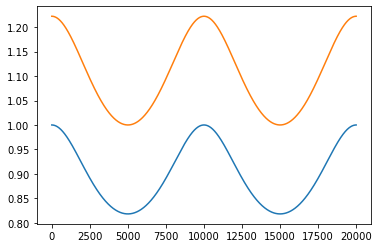

In [342]:
plt.plot(v_p / v_p.max())
plt.plot(v_star / v_star.max())

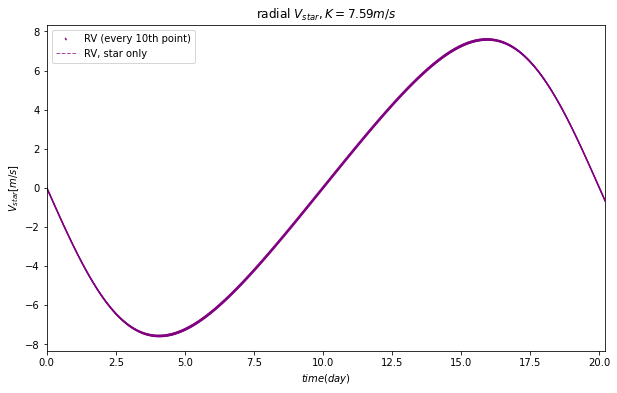

In [343]:
# figure setup
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()

plot_planet = False

# actual radial velocity
skip = 10
ax.scatter(t_array[::skip].to(u.day), rv[::skip],
            s=3, c='purple', lw=1, ls='dotted',label=f"RV (every {skip}th point)")
ax.plot(t_array[::skip].to(u.day), rv[::skip],
           c='purple', lw=1, alpha=0.7, ls='dashed',label=f"RV, star only")

# recall that rmrv = dvrot + rv
scale = 1
# ax.plot(t_array.to(u.day), dvrot*scale + rv, 
#         c = 'olivedrab',
#         label=f"RV + R-M (scaled by {scale})")

# plot just the r-m distrubance
scale = 1
# ax.plot(t_array.to(u.day), dvrot*scale, 
#         c = 'olivedrab',
#         label=f"R-M only (scaled by {scale})")


# formatting
ax.set_title(r"radial $V_{star}," + f"K = {rv.max():.3}$")
ax.set_xlabel(r"$time (day)$")
ax.set_ylabel(r"$V_{star} [m/s]$")

#xl, xr = 2*np.pi - 0.05, 2*np.pi + 0.05 # (29/15)*np.pi,(31/15)*np.pi
ax.set_xlim(0, 1.01*P.value)
#ax.set_ylim(-1,1)
#ax.hlines(0,xl,xr, ls='--', colors='grey')
plt.legend()

# check against juliet and/or phoebe

# build in functionality for star spots and alternative geometry


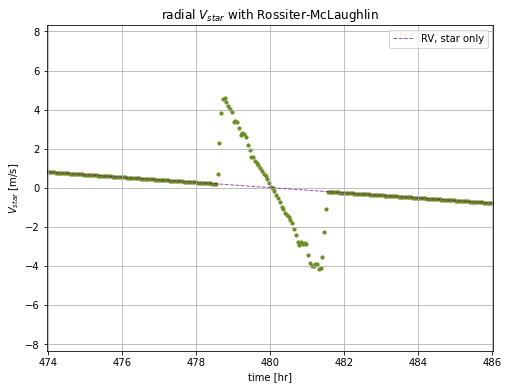

In [344]:
# figure setup
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

# actual radial velocity
skip = 1
#ax.scatter(thetas, rv,
#           c='pink', label=f"RV with R-M")
ax.plot(t_array[::skip].to(u.hr), rv[::skip],
           c='purple', lw=1, alpha=0.7, ls='dashed',label=f"RV, star only")

# ax.scatter(t_array[::skip].to(u.hr), rv[::skip],
#            c='purple', lw=1, ls='dotted',label=f"RV (every {skip}th point)")


# recall that rmrv = dvrot + rv
scale = 1
# ax.plot(t_array.to(u.hr), dvrot*scale + rv, 
#         c = 'olivedrab',
#         label=f"RV + R-M (scaled by {scale})")
ax.scatter(t_array.to(u.hr), dvrot*scale + rv, 
        c = 'olivedrab', s=10,
        label=f"_RV + R-M (scaled by {scale})")


# plot just the r-m distrubance
# scale = 1
# ax.plot(t_array.to(u.hr), dvrot*scale, 
#         c = 'orange',
#         label=f"R-M (scaled by {scale})")


# additional visual markers
# ax.vlines((P).to(u.h).value,ax.get_ylim()[0],ax.get_ylim()[1],
#           color='grey', alpha=0.4 , label=f"P = {P}")
#ax.hlines(0,xl,xr, ls='--', colors='grey')

# formatting
ax.set_title(r"radial $V_{star}$ with Rossiter-McLaughlin")
ax.set_xlabel(r"time [hr]")
ax.set_ylabel(r"$V_{star}$ [m/s]")

middle = P.to(u.hr).value  # 1 to start at 0
window = 2*dur/P
ax.set_xlim(middle*(1-window), middle*(1+window))
#ax.set_xlim((1*dur*[-1,1]).value)
#ax.set_xlim(1.01*P.to(u.hr).value,0.99*P.to(u.hr).value)
#ax.set_ylim(-5,5)

plt.grid()
plt.legend()


In [345]:
# pack up the rv light curve
rv_lc = np.array(list(zip(t_array.to(u.day).value, rv.value, thetas)))

In [346]:
rv_lc

array([[ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [ 2.00010001e-03, -6.38056597e-03,  7.71767277e-04],
       [ 4.00020001e-03, -1.27611268e-02,  1.54353451e-03],
       ...,
       [ 3.99959998e+01,  2.68069001e-02,  1.25631282e+01],
       [ 3.99979999e+01,  2.04263721e-02,  1.25638999e+01],
       [ 4.00000000e+01,  1.40458264e-02,  1.25646717e+01]])

In [347]:
np.savetxt("rv_lc.csv", rv_lc, 
           fmt="%.8f", 
           delimiter=",",
           header=header
          )

# -----real stuff ends here----

Text(0, 0.5, '$V_{star} [m/s]$')

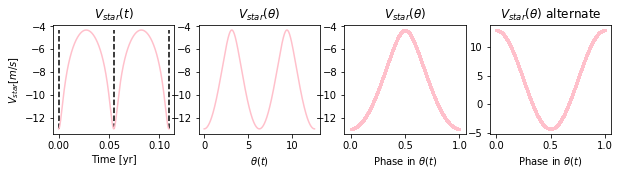

In [23]:
# plot total velocity quantities

## plot planet total velocity vs time
#plt.plot(t_array,v_p[:-1],label=r"$v_{p}$")

# set up plot
plt.rc('font',size=10) 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(10,2))

# plot star velocity vs time
ax1.plot(t_array.to(u.yr),v_star,label=r"$v_{*}$",c='pink')

# plot regions where planet transits
for t in t_conj:
    ylow, yhigh = v_star.value.min(), v_star.value.max()
    ax1.vlines(t.value, ylow, yhigh,linestyle='dashed')
# formatting
ax1.set_xlabel("Time [yr]")
ax1.set_title(r"$V_{star}(t)$")

# plot star total velocity vs. thetas
ax2.plot(thetas, v_star,label=r'$v_{star}$', c='pink')
ax2.set_xlabel(r"$\theta(t)$")
ax2.set_title(r"$V_{star}(\theta)$")

# plot phase-folded star total velocity vs. thetas
folded_thetas = [(t/(2*np.pi)) - (t/(2*np.pi) - ((t/(np.pi*2)) % (1)) )for t in thetas ]
ax3.scatter(folded_thetas, v_star,label=r'$v_{star}$', c='pink',s=3)
ax3.set_xlabel(r"Phase in $\theta(t)$")
ax3.set_title(r"$V_{star}(\theta)$")

# calculate the line-of-sight radial velocity (I don't think this is quite right)
inc = incl # np.pi/2
arg_peri = 0.
dzdt = ((np.pi * 2)/P)* a * np.sin(inc)* np.power(1 - e**2, -0.5) * \
    (np.cos([arg_peri + t for t in thetas]) +  e * np.cos(arg_peri) ) 
rvz = ((mp/(mp + mstar)) * dzdt).decompose()
ax4.scatter(folded_thetas, rvz, s=3, c='pink')
ax4.set_xlabel(r"Phase in $\theta(t)$")
ax4.set_title(r"$V_{star}(\theta)$ alternate")


# add labels
#for ax in [ax1, ax2, ax3, ax4]: ax.set_ylabel(r"$V_{star} [m/s]$")
ax1.set_ylabel(r"$V_{star} [m/s]$")



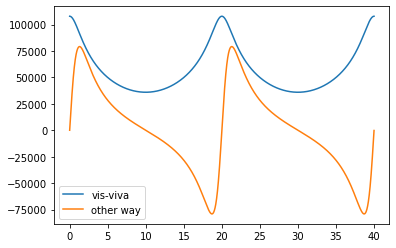

In [390]:
plt.plot(t_array.to(u.day), vv.decompose(), label='vis-viva') # vis-viva way
plt.plot(t_array.to(u.day), rvp.decompose(), label='other way') # other way?

plt.legend()

In [227]:
t_array.decompose()

<Quantity [0.00000000e+00, 1.72886443e+03, 3.45772886e+03, ...,
           3.45254227e+06, 3.45427114e+06, 3.45600000e+06] s>

In [162]:
(dur/P).decompose()

<Quantity 0.00400791>

In [144]:
ax.get_ylim()

(-11.281085717976671, 11.281364868426724)

In [136]:
rv.max(), rv.min()

(<Quantity 7.47836235 m / s>, <Quantity -7.47836235 m / s>)

In [55]:
# pack up the rv light curve
rv_lc = np.array(list(zip(t_array.to(u.hr).value, rmrv.value)))

In [86]:
(t_array / P)

<Quantity [0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
           0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
           0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
           0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
           0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
           0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
           0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
           0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
           0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
           0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
           0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
           0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
           0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
           0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
      

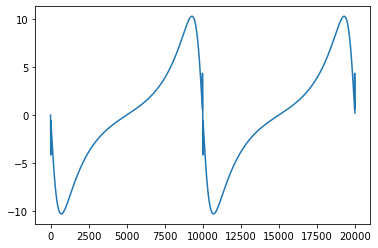

In [394]:
plt.plot( rmrv)

In [76]:
[(t/(2*np.pi)) - (t/(2*np.pi) - ((t/(np.pi*2)) % (1)) )for t in thetas ]

[0.0,
 0.0034641016151377626,
 0.006927656244464411,
 0.01038957077980947,
 0.013848755217434661,
 0.017304125056097623,
 0.020754603666052463,
 0.024199124615791073,
 0.027636633943759856,
 0.031066092362847773,
 0.03448647738612513,
 0.03789678536310573,
 0.04129603341669644,
 0.0446832612719728,
 0.048057532968961904,
 0.051417938452709096,
 0.054763595035036104,
 0.05809364872354917,
 0.061407275414611044,
 0.064703681948134,
 0.06798210702316951,
 0.07124182197434935,
 0.07448213141026176,
 0.07770237371581358,
 0.08090192142152738,
 0.08408018144354361,
 0.08723659519883578,
 0.09037063860079979,
 0.09348182194094162,
 0.09656968966286303,
 0.09963382003513117,
 0.10267382472991769,
 0.10568934831450963,
 0.10868006766293155,
 0.11164569129498071,
 0.11458595864997048,
 0.11750063930240735,
 0.1203895321266999,
 0.12325246441782078,
 0.12608929097462124,
 0.12889989315223815,
 0.1316841778897434,
 0.13444207671886968,
 0.13717354475931048,
 0.1398785597057431,
 0.1425571208113643

Text(0, 0.5, 'dtheta')

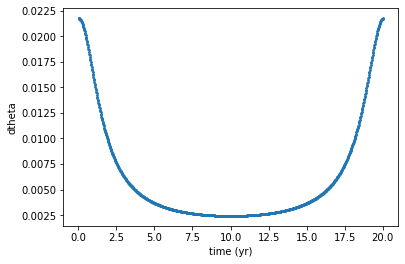

In [28]:
# plot dtheta for each time step
#   for a circular orbit, the plot will be a flat line 
plt.scatter(t_array[1:], np.diff(thetas),s=3)

# add labels
plt.xlabel("time (yr)")
plt.ylabel("dtheta")


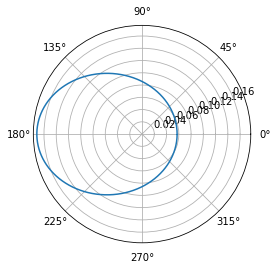

In [29]:
# plot path of ellipse
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot(thetas, [i.value for i in r])

# add labels
#ax.set_rmax(7)
#ax.set_rticks([2,4,6,8])  # Fewer radial ticks ([0.5, 1, 1.5, 2])
#ax.set_rlabel_position(-30.5)  # Move radial labels away from plotted line
ax.grid(True)


In [30]:
vrot * orbit_drvs

<Quantity [ 0.        , -4.77180421, -0.02149461,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
            

In [31]:
drvs

array([ 0.00000000e+00, -5.65907874e-03, -2.54913457e-05,  0.00000000e+00,
        0.00000000e+00,  2.54913457e-05,  5.35318259e-03])

In [32]:
orbit_drvs[-5:]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.54913457e-05,
       5.35318259e-03])

In [33]:
rv[-5:]

<Quantity [1.40188788, 1.12330718, 0.8434515 , 0.56262427, 0.28113255] m / s>

In [34]:
-0.079811915 * -0.01063259

0.00084860736930985

In [35]:
foo = np.abs(rv) * orbit_drvs
foo[0:4], foo[-4:], foo[-4:] + rv[-4:], rmrv[-4:]

(<Quantity [ 0.00000000e+00, -1.59524065e-03, -1.43647314e-05,
             0.00000000e+00] m / s>,
 <Quantity [0.00000000e+00, 0.00000000e+00, 1.43420496e-05, 1.50495386e-03] m / s>,
 <Quantity [1.12330718, 0.8434515 , 0.56263861, 0.2826375 ] m / s>,
 <Quantity [1.12330718, 0.8434515 , 0.58411888, 4.79500139] m / s>)

In [36]:
rv[0:10],rmrv[0:10]

(<Quantity [-0.        , -0.28189052, -0.56351405, -0.84455989, -1.12471923,
            -1.40368626, -1.68115928, -1.95684171, -2.23044313, -2.50168026] m / s>,
 <Quantity [ 0.        , -5.05369473, -0.58500866, -0.84455989, -1.12471923,
            -1.40368626, -1.68115928, -1.95684171, -2.23044313, -2.50168026] m / s>)

# toy model for star

star as a carton of neapolitan ice cream: 
 * bubble gum (moving twoards), vanilla, cherry (moving away)
 
rough velocity : $ \frac{2\pi R_*}{star rotation periods}$

R-M amplitude:
* stellar rotation speed (slower - bigger amplitude)
* (Rp/Rstar)**2

# dreams 

* sample of M dwarfs with activity information:
    * Newton+, has spectra info
        * active: has $H\alpha$, which means has lots of ionization
        * m dwarfs never die! we can assume the population is close to the M dwarf IMF
    * Chontos?